# Green Prism — Transparency Model from TXT Disclosures (Minimal)

This notebook trains a transparency score regressor **only from raw TXT disclosure files**.

It does **not** depend on `bonds.csv`. Each `.txt` is treated as one disclosure document.


## 1. Imports & Path Setup

In [1]:
from pathlib import Path
import sys

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor

import torch
from transformers import AutoTokenizer, AutoModel

NOTEBOOK_DIR = Path.cwd().resolve()
REPO_ROOT = NOTEBOOK_DIR.parents[3]
BACKEND_ROOT = REPO_ROOT / "backend"

sys.path.insert(0, str(BACKEND_ROOT))

from app.ml.preprocessing import clean_text
from app.ml.transparency_model import score_transparency


/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Load TXT Disclosures

In [3]:
TEXT_DIR = BACKEND_ROOT / "app" / "data" / "disclosures_texts"
print("TEXT_DIR:", TEXT_DIR)

files = sorted(TEXT_DIR.glob("*.txt"))
print("Found TXT files:", len(files))

texts = []
filenames = []

for f in files:
    try:
        txt = f.read_text(encoding="utf-8")
    except Exception as e:
        print("Error reading", f, e)
        txt = ""
    texts.append(txt)
    filenames.append(f.name)

df = pd.DataFrame({
    "disclosure_id": range(len(files)),
    "filename": filenames,
    "raw_text": texts,
})

df.head()


TEXT_DIR: /Users/radhamunver/Downloads/GreenPrism/green-prism/backend/app/data/disclosures_texts
Found TXT files: 62


,disclosure_id,filename,raw_text
0,0,20161018_SNCF_oekom_CBI_pre-issuance-verificat...,page 1 \n \n SNCF Réseau commissioned oekom r...
1,1,2021-Post-Bond-Issuance-Verification-Report.txt,Kestrel Verifiers | Clim a te Bonds Pos t-Is...
2,2,2025.08.13_Bart-Verification-Report.txt,BART Climate Bonds External Pre-Issuance \nVer...
3,3,320251006_TOKYO-Resilience-Bond-SPO_en.txt,Second Opinion \n \n \n \n \n Rating and Inve...
4,4,4PRE-I_1.txt,Pre-Issuance Verification Report\nfor the Firs...


## 3. Clean Text & Compute Rule-Based Teacher Scores

In [4]:
df["clean_text"] = df["raw_text"].fillna("").astype(str).apply(clean_text)

df["teacher_transparency_score"] = df["clean_text"].apply(
    lambda t: score_transparency(t).overall
)

print(df[["filename", "teacher_transparency_score"]].head())
df["teacher_transparency_score"].describe()


                                            filename  \
0  20161018_SNCF_oekom_CBI_pre-issuance-verificat...   
1    2021-Post-Bond-Issuance-Verification-Report.txt   
2            2025.08.13_Bart-Verification-Report.txt   
3         320251006_TOKYO-Resilience-Bond-SPO_en.txt   
4                                       4PRE-I_1.txt   

   teacher_transparency_score  
0                        59.0  
1                        88.9  
2                        88.1  
3                        88.7  
4                        88.2  


count    62.000000
mean     84.719355
std       7.322161
min      59.000000
25%      82.050000
50%      88.100000
75%      88.600000
max      94.000000
Name: teacher_transparency_score, dtype: float64

## 4. Handcrafted Pattern Features

In [5]:
import re

PATTERNS = {
    "has_third_party_review": [
        r"second[- ]party opinion",
        r"external review",
        r"third[- ]party verification",
        r"assurance",
        r"spo by",
        r"sustainalytics",
        r"cicero",
        r"vigeo",
    ],
    "has_reporting_annual": [
        r"annual report",
        r"annual reporting",
    ],
    "has_reporting_semi_annual": [
        r"semi[- ]annual",
        r"semiannual",
    ],
    "has_kpi_co2": [
        r"\bco2\b",
        r"carbon emissions",
        r"greenhouse gas",
        r"\bghg\b",
    ],
    "has_kpi_energy": [
        r"mwh",
        r"kwh",
        r"kw\b",
        r"energy efficiency",
        r"renewable energy",
    ],
}

def handcrafted_features(text: str) -> np.ndarray:
    t = text.lower()
    feats = []

    for patterns in PATTERNS.values():
        flag = any(re.search(p, t) for p in patterns)
        feats.append(1.0 if flag else 0.0)

    # Count numeric tokens (targets, baselines, etc.)
    num_numbers = len(re.findall(r"\d+(?:\.\d+)?", t))
    feats.append(float(num_numbers))

    return np.array(feats, dtype=np.float32)

handcrafted_dim = len(PATTERNS) + 1
print("Handcrafted feature dim:", handcrafted_dim)

# Quick sanity check on first doc
if len(df) > 0:
    example_feats = handcrafted_features(df["clean_text"].iloc[0])
    example_feats, example_feats.shape
else:
    print("No disclosures loaded!")


Handcrafted feature dim: 6


## 5. Load FinBERT/BERT and Build Embeddings

In [6]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_NAME = "ProsusAI/finbert"  # change to 'bert-base-uncased' if needed

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
model.to(DEVICE)
model.eval()

print("Loaded model:", MODEL_NAME, "on", DEVICE)


Loaded model: ProsusAI/finbert on cpu


In [7]:
from typing import List

@torch.no_grad()
def embed_texts(texts: List[str], batch_size: int = 4) -> np.ndarray:
    all_embs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i : i + batch_size]
        enc = tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=256,
            return_tensors="pt",
        )
        enc = {k: v.to(DEVICE) for k, v in enc.items()}

        outputs = model(**enc)
        cls_emb = outputs.last_hidden_state[:, 0, :]  # CLS token
        all_embs.append(cls_emb.cpu().numpy())
    return np.vstack(all_embs)


## 6. Build Feature Matrix X and Target y

In [8]:
texts_clean = df['clean_text'].tolist()
y = df['teacher_transparency_score'].values.astype('float32')

if len(texts_clean) == 0:
    raise RuntimeError("No disclosures loaded. Put .txt files into disclosures_texts/.")

print('Embedding texts...')
cls_embeddings = embed_texts(texts_clean, batch_size=4)
print('CLS embeddings shape:', cls_embeddings.shape)

handcrafted = np.stack(
    [handcrafted_features(t) for t in texts_clean],
    axis=0
)
print('Handcrafted shape:', handcrafted.shape)

X = np.concatenate([cls_embeddings, handcrafted], axis=1)
X.shape, y.shape


Embedding texts...
CLS embeddings shape: (62, 768)
Handcrafted shape: (62, 6)


((62, 774), (62,))

## 7. Train GradientBoostingRegressor

In [10]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

gbr = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    random_state=42,
)

gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print(f'Validation RMSE: {rmse:.3f}')
print(f'Validation R^2: {r2:.3f}')
print('Teacher stats: mean', y_val.mean(), 'std', y_val.std())
print('Pred stats:   mean', y_pred.mean(), 'std', y_pred.std())


Validation RMSE: 10.591
Validation R^2: -0.108
Teacher stats: mean 82.284615 std 10.060726
Pred stats:   mean 85.40133160437914 std 2.8451860457610456


### 7.1 Diagnostic Plot

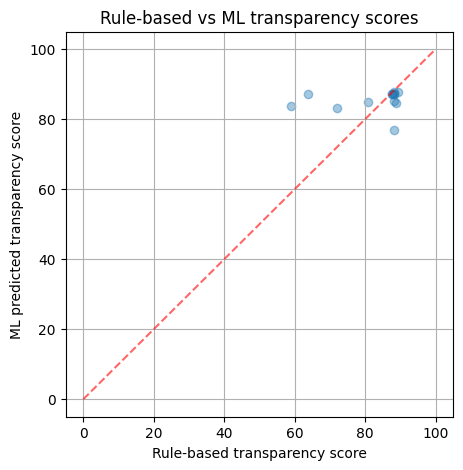

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(y_val, y_pred, alpha=0.4)
plt.xlabel('Rule-based transparency score')
plt.ylabel('ML predicted transparency score')
plt.title('Rule-based vs ML transparency scores')
plt.plot([0,100],[0,100],'r--',alpha=0.6)
plt.grid(True)
plt.show()


## 8. Save Model & Define Inference Helper

In [12]:
from joblib import dump

MODEL_DIR = BACKEND_ROOT / 'app' / 'models'
MODEL_DIR.mkdir(parents=True, exist_ok=True)
MODEL_PATH = MODEL_DIR / 'transparency_regressor_from_txt.joblib'

def clamp_0_100(val: np.ndarray) -> np.ndarray:
    return np.clip(val, 0.0, 100.0)

artifact = {
    'model': gbr,
    'feature_dim': X.shape[1],
    'handcrafted_dim': handcrafted_dim,
    'base_nlp_model_name': MODEL_NAME,
}

dump(artifact, MODEL_PATH)
print('Saved model to:', MODEL_PATH)


Saved model to: /Users/radhamunver/Downloads/GreenPrism/green-prism/backend/app/models/transparency_regressor_from_txt.joblib


In [13]:
from joblib import load

def load_trained_model(model_path: Path = MODEL_PATH):
    return load(model_path)

def predict_transparency_score_ml(text: str, artifact: dict) -> float:
    cleaned = clean_text(text)
    emb = embed_texts([cleaned])          # (1, hidden)
    hand = np.stack([handcrafted_features(cleaned)], axis=0)  # (1, H)
    feats = np.concatenate([emb, hand], axis=1)               # (1, D)
    score = artifact['model'].predict(feats)[0]
    return float(clamp_0_100(score))

artifact_loaded = load_trained_model()
example_text = df['clean_text'].iloc[0]
print('Example file:', df['filename'].iloc[0])
print('ML transparency score:', predict_transparency_score_ml(example_text, artifact_loaded))
print('Rule-based score:', score_transparency(example_text).overall)


Example file: 20161018_SNCF_oekom_CBI_pre-issuance-verification.txt
ML transparency score: 83.72856610755333
Rule-based score: 59.0
